In [8]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

In [9]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

# device = torch.device('cuda')

In [10]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# filter training imgs
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


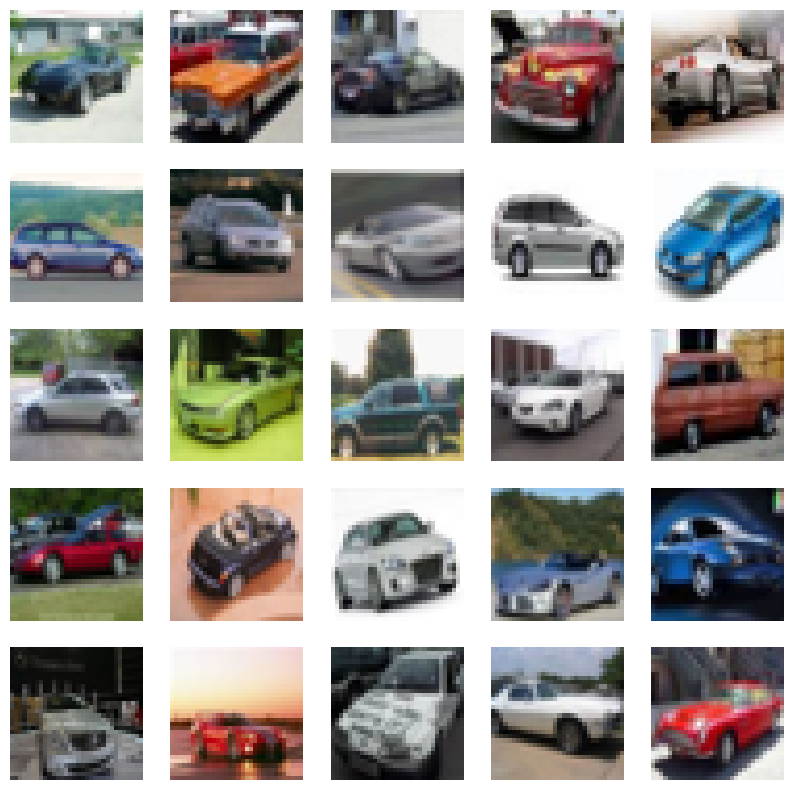

In [11]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

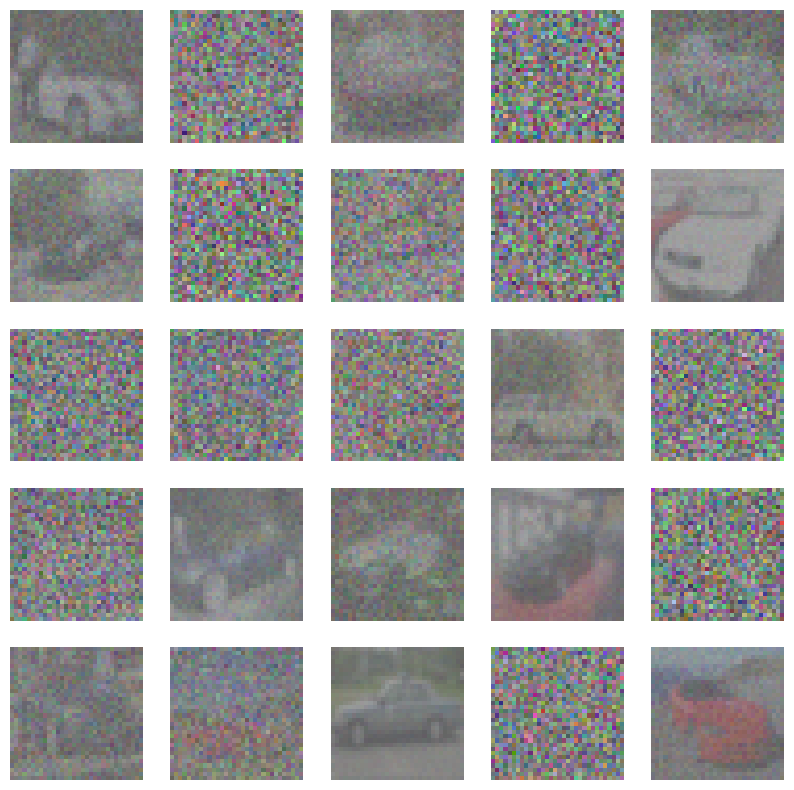

In [12]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

In [13]:
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()
        
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [14]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )
        
        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)
        
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )
        
        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)
        
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
        
        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)
    
    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)
        
        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)
                
        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)
        
        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]
        
        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            
            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # ----- output -----
        x = self.cnn_output(x)

        return x

model = Model()

  0%|          | 0/16 [00:00<?, ?it/s]

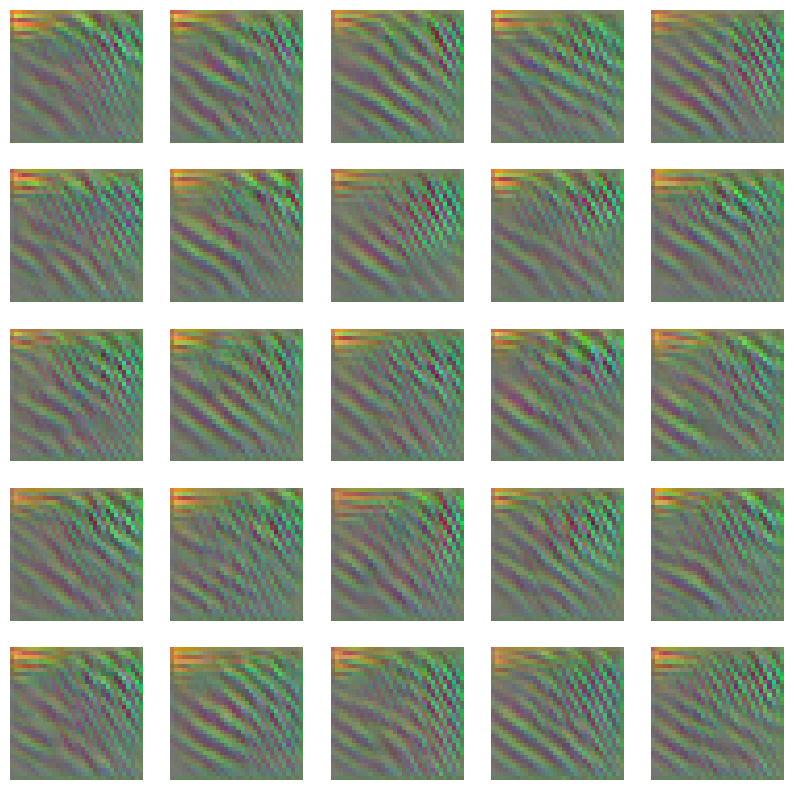

In [16]:
def predict(x_idx=None):
    x = torch.randn(32, 3, IMG_SIZE, IMG_SIZE)
    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float))

    show_examples(x.cpu())

predict()

  0%|          | 0/16 [00:00<?, ?it/s]

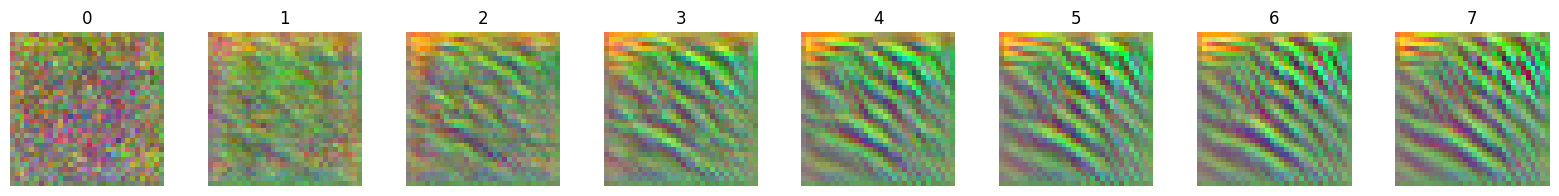

In [18]:
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE))

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [19]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    
    x_ts = torch.from_numpy(x_ts).view(-1, 1).float()
    x_a = x_a.float()
    x_b = x_b.float()
    
    y_p = model(x_a, x_ts)
    loss = torch.mean(torch.abs(y_p - x_b))
    model.opt.zero_grad()
    loss.backward()
    model.opt.step()
    
    return loss.item()

In [20]:
def train(R=50):
    bar = trange(R)
    total = len(trainloader)
    for i in bar:
        for j, (x_img, _) in enumerate(trainloader):
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

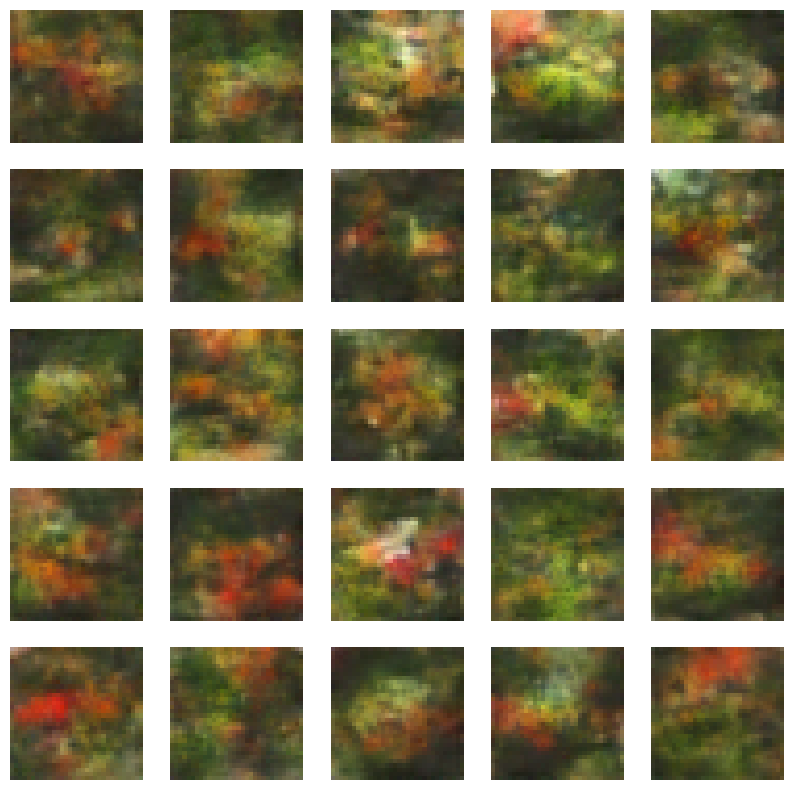

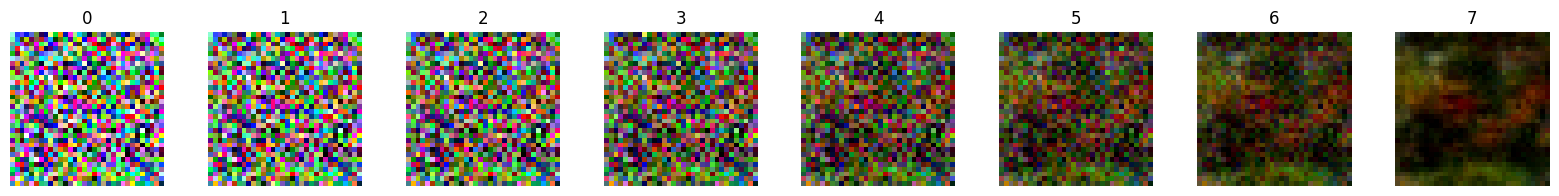

In [22]:
for _ in range(1):
    train()
    # reduce learning rate for next training
    for pg in model.opt.param_groups:
        pg['lr'] = max(0.000001, pg['lr'] * 0.9)

    # show result 
    predict()
    predict_step()
    plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

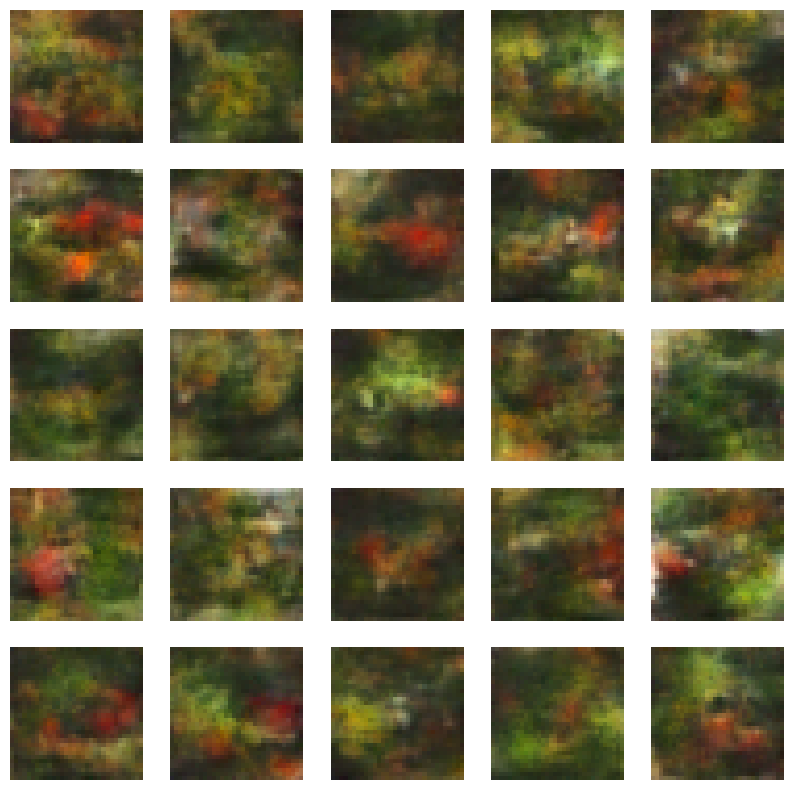

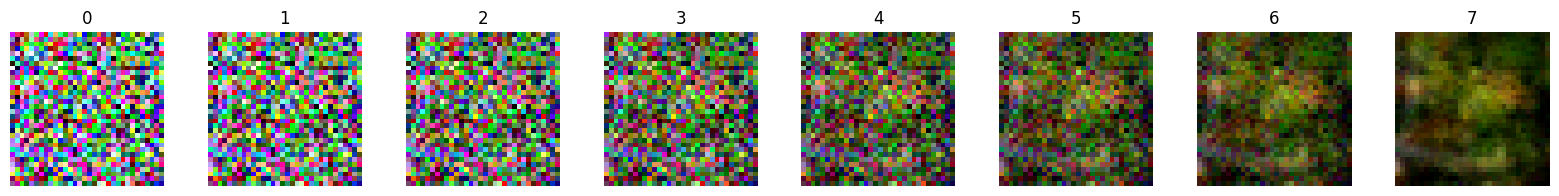

In [23]:
predict()
predict_step()